## Project: **Finding Lane Lines on the Road** 
***
 [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) 
 [rubric points](https://review.udacity.com/#!/rubrics/322/view)  

---
First test image: 'test_images/solidWhiteRight.jpg'.  

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**Tools:
color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

## Import Packages

In [234]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
%matplotlib inline

## Useful numpy functions

`np.polyfit((x1,x2),(y1,y2))`  Fit lines (y=Ax+B) , return [A, B]

## Useful OpenCV functions

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image


`cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)` apply grayscal transform
`cv2.Canny(img, low_threshold, high_threshold)` apply canny transform
`cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)` apply gaussian noise kerel


## Helper Functions from Udacity

In [235]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    
    Attention: vertices in form (col, row)  (x,y)
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    # compute intersection
    # m1 * x1 + b1 = y1
    # m2 * x2 + b2 = y2
    # (m2*x2 - m1*x1) + (b2- b1) = y2-y1
    # (m2 - m1) * x_inter + (b2 - b1) = y_inter
    # x_inter = (m2 - m1) / (b2 - b1) 
    # y_inter = m1 * x_inter + b1
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    # modified this to use the new helper function I implemented
    draw_two_lines(line_img, lines)
    return line_img

## Helper Function 
My implementation of helper functions

In [ ]:
def removeOutlier_mean(values):
    # remove outliers using standard deviation and calculate mean
    mean_val = np.mean(values, axis=0)
    sd = numpy.std(values, axis=0)
    
    trim = [x for x in values if (x > mean_val - sd)]
    return np.mean(values)

# extrapolate / average lines from Hogh Transform into only left and right lines
def two_lanes(lines, image_shape):
    # slope and bias for left lane
    m_left = np.array([])
    b_left = np.array([])
    
    y_min = image_shape[0]
    # calculate slope and bias for every line
    # line :  (x1, y1, x2, y2) end points
    for line in lines:
        y_min = min(line[1], min(line[3], y_min))
        #np.polyfit((x1,x2),(y1,y2))
        fit = np.polyfit((line[0],line[2]), (line[1],line[3]))
        m = fit[0]
        b = fit[1]
        # left lane
        if (m>0):
            np.append(m_left, m)
            np.append(b_left, b)
        # right lane
        else:
            np.append(m_right, m)
            np.append(b_left, b)
    
    # obtain mean for slope and bias
    mean_m_left = removeOutlier_mean(m_left)
    mean_m_right = removeOutlier_mean(m_right)
    mean_b_left = removeOutlier_mean(b_left)
    mean_b_right = removeOutlier_mean(b_right)
    # compute end points for left and right lines
    y_left_close = image_shape[0]
    y_right_close = image_shape[0]
    
    # the end of line close to driver
    x_left_close = (y_left_close - mean_b_left) / mean_m_left
    x_right_close = (y_right_close - mean_b_right) / mean_m_right
    # the end of line far away from driver, horizon direction
    # y_left_far == y_right_far == y_min
    x_left_far = (y_min - mean_b_left) / mean_m_left
    x_right_far = (y_min - mean_b_right) / mean_m_right
    # question: np.array([[]])?
    lineLeft= [x_left_close, y_left_close, x_left_far, y_min]
    lineRight= [x_right_close, y_right_close, x_right_far, y_min]
    twoLines = np.array([lineLeft, lineRight]).astype(int)
    
    return twoLines

def draw_two_lines(img, twoLines):
    blank = np.zeros(img.shape, dtype=np.uint8)
    draw_lines(blank, twoLines, color=[255, 0, 0], thickness=10)
    combo = cv2.addWeighted(color_edges, 0.8, input_image, 0.1, 0)
    return combo

In [248]:
# test
m_left = np.array([])
np.append(m_left, 1)


array([1.])

## Test Images

In [236]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

Summary of my implementation:
1. RGB to grayscale, apply Gaussian smoothing to remove noise and easier to find edge: 
    ouput img_blur
2. Canny edge detection, output img_edges
3. Use cv2.fillPoly to ignore everything outside region of interst, 
    input: img_edges,      output: img_edges_masked
4. Hough transform to detect lines in an image, 
    input : img_edges_masked,  output: img_lines
5. Extrapolate line segments, superimpose on the original image, output as final result

In [237]:
# My pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

# draw red lane lines on the original test_images
def lane_lines(input_image):
    # step 1. RGB to grayscale
    img_gray = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY)
    print("img_gray")
    plt.imshow(img_gray, cmap="gray")
    plt.show()
    
    # step 1. Gaussian smoothing
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    # standard deviation = 0 for Gaussian blur
    img_blur = cv2.GaussianBlur(img_gray,(kernel_size, kernel_size),0)
    
    # step 2. Canny edge detector 
    # Define our parameters for Canny and apply
    low_threshold_canny = 50
    high_threshold_canny = 150
    img_edges = cv2.Canny(img_gray, low_threshold_canny, high_threshold_canny)
    print("img_edges")
    plt.imshow(img_edges, cmap="gray")
    plt.show()
    
    # step 3. mask by region
    # Define a four sided polygon to mask
    imshape = input_image.shape
    # Attention: vertices in form (col, row)  (x,y)
    vertices = np.array([[(0,imshape[0]),(450, 315), (480, 315), (imshape[1],imshape[0])]], dtype=np.int32)
    
    img_edges_masked = region_of_interest(img_edges, vertices)
    print("img_edges_masked")
    plt.imshow(img_edges_masked)
    plt.show()
    
    
    # step 4. Hough transform to detect lines in an image, 
    # input : img_edges_masked, 
    # output: img_lines
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # one degree , angular resolution in radians of the Hough grid
    # at least 15 points in image space need to be associated with each line segment
    threshold = 15     # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 40 #minimum number of pixels making up a line
    max_line_gap = 20    # maximum gap in pixels between connectable line segments
    img_lines = hough_lines(img_edges_masked, rho, theta, threshold, min_line_len, max_line_gap)
    print("img_lines")
    plt.imshow(img_lines)
    plt.show()
    
    
    # Step 5
    # Create a "color" binary image to combine with line_img
    # stack masked_edges (width*height) to make a color_edges (width*height*3)
    # to match the dimension of line_img (width*height*3)

    # dstack: Stack arrays in sequence depth wise (along third axis).
    color_edges = np.dstack((img_edges_masked, img_edges_masked, img_edges_masked))
    print("color edges, stack of gray images, (width*height*3)")
    plt.imshow(color_edges)
    plt.show()

    # draw the lines on the edge image
    # addWeighted:  dst = src1*alpha + src2*beta + gamma
    # blend two images, weighted sum of two images
    # combo = color_edges * 0.8 + line_image*1 + 0
    
    combo = cv2.addWeighted(color_edges, 0.8, input_image, 0.1, 0)
    print("draw the lines on the edge image")
    plt.imshow(combo)
    plt.show()
    
    
    
    


This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
img_gray


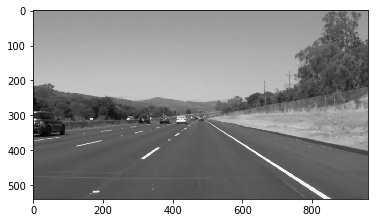

img_edges


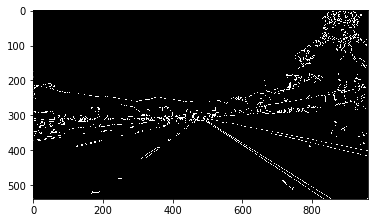

img_edges_masked


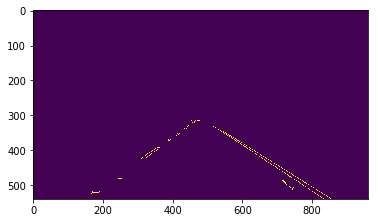

img_lines


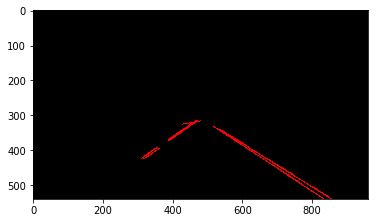

color edges, stack of gray images, (width*height*3)


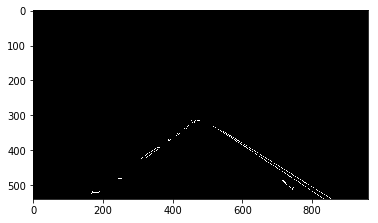

draw the lines on the edge image


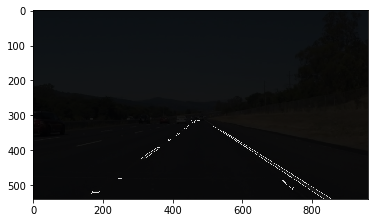

In [238]:
## Test on images
#reading in an image
test_image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(test_image)

lane_lines(test_image)




## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))